### 1) Load necessary Python packages

In [9]:
import os
import sys
import dill

# Add the local src directory to the path
sys.path.append('./src/')

# Load the GBA_model class
from GBA_model import *

### 2) Define a function to load a model from a binary backup
See the script `csv_to_binary.py`.

In [10]:
### Load the model from a binary file ###
def load_model( model_name ):
    filename = "./binary_models/"+model_name+".gba"
    assert os.path.isfile(filename), "ERROR: model not found."
    ifile = open(filename, "rb")
    model = dill.load(ifile)
    ifile.close()
    return model

### 3) Load the model "EC12b" (a very abstract model of <em>E. coli</em>)

In [11]:
# I previously saved the model as a binary file with the script `csv_to_binary.py`
model = load_model("B")

### 4) Define the condition
The condition defines the environmental state of the cell (the composition of the medium). External concentrations are stored in the vector $x$.
Conditions are listed for the EC12b model in `./csv_models/EC12b/conditions.csv`.
We will use the condition 1.

In [12]:
model.set_condition("1")

In [13]:
model.solve_local_linear_problem()

### 6) Calculate all model variables

In [14]:
model.calculate()

In [15]:
def trajectory(model,max_time=1000,first_dt = 0.01,dt_changeRate=0.1):
  threshold = 1e-5                   # for gradient "=" 0
  dt = first_dt
  t = 0                              # time
  consistent_f = np.copy(model.f_trunc) # safes consistent_f
  next_f = np.copy(model.f_trunc)     # the f_trunc, that we are going to change
  #allGCC_F = [model.GCC_f[1:]]       # to collect all previous GCC_f (just for checking the change of GCC_f)
  print("first next_f: ")
  print(next_f)
  print("first GCC_f: ")
  print(model.GCC_f)
  y_muRates = []                      #save muRates for plotting
  timestamps = []                     #save timeStamps for plotting
  while (t < max_time):                                                                 # end loop if time is up

    if( ( np.abs(model.GCC_f) <= threshold ).all() and model.consistent):
      print("absolute of GCC_F is less then threshold in GCC_F :", model.GCC_f)
      break
    
    
    next_f = np.add(next_f, model.GCC_f[1:] * dt)                                      # add without first index of GCC_f
    #print(f"np.add({next_f}, {model.GCC_f[1:]} * {dt})")                                  # shows the term sum of next_f and GCC_f
    model.set_f(next_f)
    model.calculate()                                                           #calculate everything
 
    #allGCC_F = np.vstack((allGCC_F,model.GCC_f[1:]))                            # collects all previous GCC_f (just for checking the change of GCC_f)
    model.check_model_consistency()                                               #check consistency
    if (model.consistent):
      timestamps = np.append(timestamps,t)
      y_muRates = np.append(y_muRates,model.mu)
      t = t + dt                                                                  # calc. new t
      consistent_f = next_f                                                       # saves new f as the consistent f

    else:
      next_f = consistent_f                                                       #resets next_f to last consistent_f
      model.set_f(consistent_f)

      if (dt > 1e-100):                                                           # make sure dt is not too small
       dt = dt * dt_changeRate
    
       t = t + dt                                                                 # calc. new t
      else:
        break
      

 
  print('Last GCC_f')
  print(model.GCC_f)
  #print(allGCC_F)
  
  return timestamps, y_muRates 

timestamps,muRates = trajectory(model,max_time=200,first_dt = 0.01,dt_changeRate=0.5)
print(timestamps,muRates, model.consistent)


first next_f: 
[0.96666667 0.93333333]
first GCC_f: 
[ 0.          2.0864082  -8.06052125]
>>> Model state is not consistent:
    ------------------------------
    • Density constraint: True
    • Positive c: False
    • Positive p: True
>>> Model state is not consistent:
    ------------------------------
    • Density constraint: True
    • Positive c: False
    • Positive p: False
>>> Model state is not consistent:
    ------------------------------
    • Density constraint: True
    • Positive c: False
    • Positive p: True
absolute of GCC_F is less then threshold in GCC_F : [ 0.00000000e+00 -8.49821884e-06 -9.99532427e-06]
Last GCC_f
[ 0.00000000e+00 -8.49821884e-06 -9.99532427e-06]
[0.      0.015   0.02375 ... 1.99375 1.995   1.99625] [1.14312901 1.21468921 1.23024962 ... 1.69884613 1.69884613 1.69884613] True


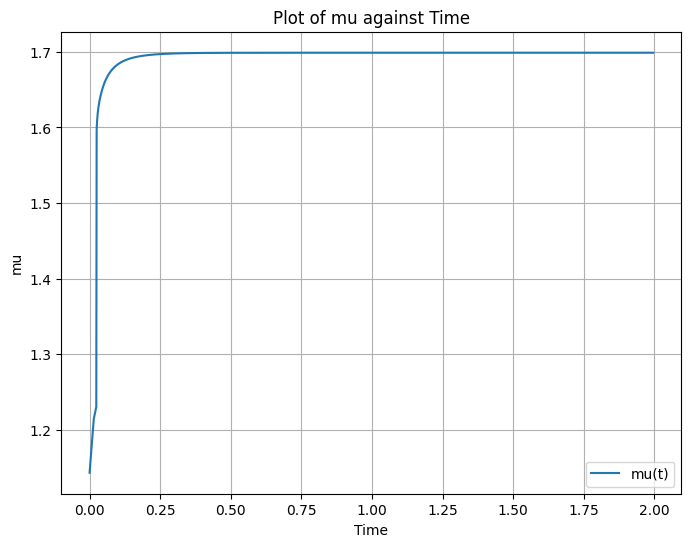

max μ rate :
1.6988461296624906


In [16]:
import matplotlib.pyplot as plt

# Daten für die Zeitachse
t = timestamps  # 100 Zeitpunkte von 0 bis 10

# Daten für die Y-Achse (Beispiel: Sinusfunktion)
mu = muRates

# Erstellung des Plots
plt.figure(figsize=(8, 6))  # Größe des Diagramms festlegen
plt.plot(t, mu, label='mu(t)')  # Plot der Daten
plt.xlabel('Time')  # Beschriftung der X-Achse
plt.ylabel('mu')    # Beschriftung der Y-Achse
plt.title('Plot of mu against Time')  # Titel des Diagramms
plt.grid(True)      # Gitterlinien aktivieren
plt.legend()        # Legende hinzufügen
plt.show()          # Diagramm anzeigen
print("max μ rate :")
print(np.max(mu))